In [1]:
import math
import string
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import itertools as itools
import matplotlib.pyplot as plt
sns.set_style("dark")

In [2]:
def paa(arr, sections):
    try:
        assert arr.shape[0] != sections
    except AssertionError as e:
        return np.copy(arr)
    else:
        if arr.shape[0] % sections == 0:
            sectionarr = np.array_split(arr, sections)
            res = np.array([item.mean() for item in sectionarr])
            res = np.array(
                [sample for item in res for sample in 
                [item.mean()] * item.shape[0]]
            )
        else:
            sectionarr = np.zeros(sections)
            space_size = np.arange(0, arr.shape[0] * sections - 1)
            outputIndex = space_size // arr.shape[0]
            inputIndex = space_size // sections
            uniques, nUniques = np.unique(outputIndex, return_counts=True)
            
            res = [arr[indices].sum() / arr.shape[0] for indices in
                   np.split(inputIndex, nUniques.cumsum())[:-1]]
            indices = ([row.mean() for row in np.split(inputIndex, nUniques.cumsum())[:-1]])
    return res

# Symbolic Aggregate Approximation (SAX)

 In literature, SAX falls under the symbolic data-adaptive time series reprsentation systems. This is a method of approximation and representation of a time series as a set of symbols. SAX enables the reduction of an arbitrary length time series (n) to be reduced to a string of arbitrary length (w) where w < n. The process of SAX is first the time series data is transformed using Piecewise Aggregate Approximation (PAA) representation which is then symbolized using SAX to a time string. 

**Discretisation**

One requirement for the discretisation technique is that the symbols are assigned by equiprobability. This is easier to achieve since normalised time series data have a Gaussian distribution. Therefore for discretisation, the equal sized areas (a) under the Gaussian curve can be used for creating breakpoints in the normalised data for assigning the symbols using breakpoints. 

**1** Breakpoints are a sorted list of numbers $\beta = \beta_1, ... \beta_{a - 1}$ such that the area under the curve from $\beta_i$ to $\beta_{i+1} = 1/a$. These points can be obtained by looking up a statistical table.

These breakpoints can be used to discretise the time series where the coefficients below the smallest breakpoint are mapped to the letter $a$ while the coefficients greater than or equal to the smallest breakpoint and less than the second breakpoint are assigned the letter $b$ and so on. Each letter is equiprobable and therefore a sequence of strings for example `abc` that represetnts the time series is called a word.

**2** Word is a subsequence $C$ of a length $n$ that can be represented as a word. If $\alpha_i$ is the ith element of the alphabet, then the mapping approximation of PAA to a word $\hat{C}$ is obtained using:

$$
\hat{c}_i = \alpha_j
$$

if $\beta_{j-1} \leq \bar{c}_i \lt \beta_j$. This defines the symbolic representation of the time series. 

In [3]:
t1 = np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34])
t2 = np.array([3.12, 2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34])

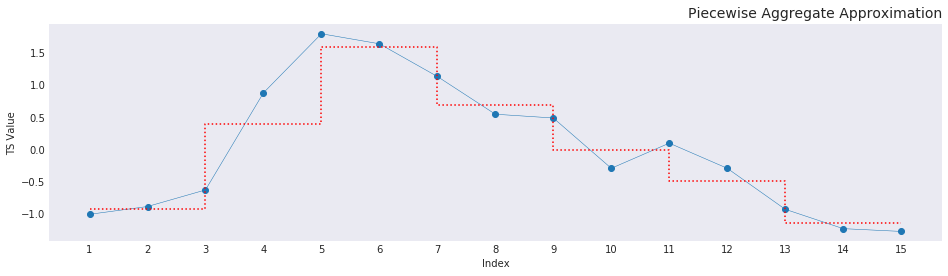

In [4]:
plt.figure(figsize=(16, 4))
plt.title("Piecewise Aggregate Approximation", size=14, loc="right")
normed_t1 = (t1 - np.mean(t1)) / np.std(t1)
plt.plot(range(1, 16), normed_t1, marker="o", linewidth=0.5)
res = paa(normed_t1, 7)
plt.step([1, 3, 5, 7, 9, 11, 13, 15], np.insert(res, 0, res[0]),
         color="red", linestyle=":")
plt.xticks(range(1, 16))
plt.xlabel("Index")
plt.ylabel("TS Value")
# plt.savefig("./PAAStepFinal.png", bbox_inches="tight")
plt.show()

The above graph is example of the PAA which we dealt with earlier. Since the data is being split in to 7 sections, the number of symbols required is 7. The equiprobable areas of the gaussian curve for the gaussian curve can be obtained from a statistical lookup table. In Python the statistical lookup table can be built using the PPF (probability point function) function available in the `scipy.stats` module.

In [5]:
def lookupEquiprobableRegions(word_len):
    """Lookup equiprobable regions"""
    regions = np.arange(0, word_len, 1) / word_len
    return sp.stats.norm.ppf(regions)

With the lookup table ready, the time series can now be assigned the letters depending on the index. This straightforward conversion can now occur with the equiprobable regions and the string list.

In [6]:
_symbols_ = string.ascii_lowercase

In [7]:
eqRegions = lookupEquiprobableRegions(7)

In [8]:
size = len(eqRegions)
paa = np.array(res)
sax = list()
# --
for i in range(0, len(res)):
    num = res[i]
    if num >= 0:
        j = size - 1
        while ((j > 0) and (eqRegions[j] >= num)):
            j = j - 1
        sym = _symbols_[j]
    else:
        j = 1
        while ((j < size) and (eqRegions[j] <= num)):
            j = j + 1
        sym = _symbols_[j]
    # --
    sax.append(sym)
# --
print("String for the section is: %s" % (''.join(sax)))

String for the section is: cegfedb


In [9]:
test = np.array(tuple(zip(eqRegions, eqRegions[1:])))

In [10]:
sax = list()
for val in paa:
    bound_high = np.where(test[:, 1] >= val)[0]
    bound_low = np.where(test[:, 0] <= val)[0]
    try:
        intersect = np.intersect1d(
            bound_high, bound_low)[0]
    except IndexError as e:
        max_bound_low = bound_low.max()
        intersect = max_bound_low + 1
    if val < 0:
        intersect += 1
    sax.append(_symbols_[intersect])

In [11]:
print("String for the section is: %s" % (''.join(sax)))

String for the section is: cegfedb
